# CLIP-Style Zero-Shot Classification on CIFAR-10
## (Training Only the Image Encoder, Frozen BERT Text Encoder)

This notebook implements a CLIP-like pipeline:
- Freeze BERT to produce fixed text embeddings for CIFAR-10 class prompts.
- Train only the ViT image encoder + a projection head to align image embeddings with the text embeddings using contrastive (InfoNCE / cross-entropy) loss.
- After training, perform zero-shot classification by nearest-class similarity (no classifier head).

Note:
- CIFAR-10 images (32×32) are resized to 224×224.
- Text embeddings use multiple prompt templates and [CLS] token from BERT.
- Training is efficient because only the image side is updated.

In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU")

!pip install -q timm transformers ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4


In [ ]:
# Cell 1: Install dependencies (run once)
!pip install torch torchvision transformers timm tqdm --quiet

In [ ]:
# Cell 2: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
import timm
import numpy as np
from tqdm import tqdm

In [ ]:
# Cell 3: Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Cell 4 (Updated): Dataset and DataLoader – Reduced batch size
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128  # Reduced from 256
accumulation_steps = 2  # Effective batch size = 128 × 2 = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = trainset.classes
print("Classes:", classes)

100%|██████████| 170M/170M [00:04<00:00, 41.4MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Cell 5: Frozen Text Encoder (BERT) + Text Embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_model = BertModel.from_pretrained('bert-base-uncased').to(device)
text_model.eval()
for param in text_model.parameters():
    param.requires_grad = False

# Multiple templates for better text embeddings (common CLIP trick)
templates = [
    "a photo of a {}.",
    "a photo of a small {}.",
    "a photo of the {}.",
    "an image of a {}.",
    "an image of the {}."
]

def encode_texts(prompts):
    inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = text_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embeddings

# Compute averaged text embeddings over templates
text_emb_list = []
for template in templates:
    prompts = [template.format(c) for c in classes]
    emb = encode_texts(prompts)
    text_emb_list.append(emb)

text_embeddings = torch.stack(text_emb_list).mean(dim=0)  # (10, 768)
text_embeddings = F.normalize(text_embeddings, dim=-1)
print("Text embeddings shape:", text_embeddings.shape)

# Cleanup: Remove BERT from GPU (no longer needed)
del text_model
del tokenizer
import gc
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Text embeddings shape: torch.Size([10, 768])


In [ ]:
# Cell 6: Image Encoder (ViT) + Projection + Logit Scale
# num_classes=0 removes the classification head → raw features (384-dim for ViT-S)
image_model = timm.create_model(
    'vit_small_patch16_224.augreg_in21k_ft_in1k',
    pretrained=True,
    num_classes=0
).to(device)

projection = nn.Linear(384, 768).to(device)  # project ViT features → BERT space

# Learnable temperature (initialized like OpenAI CLIP)
logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
# Cell 7 (Updated): Optimizer + AMP Scaler
optimizer = torch.optim.AdamW(
    list(image_model.parameters()) + list(projection.parameters()) + [logit_scale],
    lr=5e-5,
    weight_decay=0.01
)

scaler = torch.cuda.amp.GradScaler()  # For mixed precision

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

/tmp/ipython-input-1430465287.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision


Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-1703985505.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/5: 100%|██████████| 391/391 [02:34<00:00,  2.54it/s]


Epoch 1 completed - Avg Loss: 1.2821 - Train Acc: 97.27% - Test Acc: 96.42%


Epoch 2/5: 100%|██████████| 391/391 [02:25<00:00,  2.70it/s]


Epoch 2 completed - Avg Loss: 0.9950 - Train Acc: 99.24% - Test Acc: 97.49%


Epoch 3/5: 100%|██████████| 391/391 [02:28<00:00,  2.64it/s]


Epoch 3 completed - Avg Loss: 0.9714 - Train Acc: 99.64% - Test Acc: 97.46%


Epoch 4/5: 100%|██████████| 391/391 [02:26<00:00,  2.66it/s]


Epoch 4 completed - Avg Loss: 0.9568 - Train Acc: 99.60% - Test Acc: 97.31%


Epoch 5/5: 100%|██████████| 391/391 [02:26<00:00,  2.68it/s]


Epoch 5 completed - Avg Loss: 0.9451 - Train Acc: 99.58% - Test Acc: 97.39%
Final model checkpoint saved to 'checkpoints/final_model.pth'


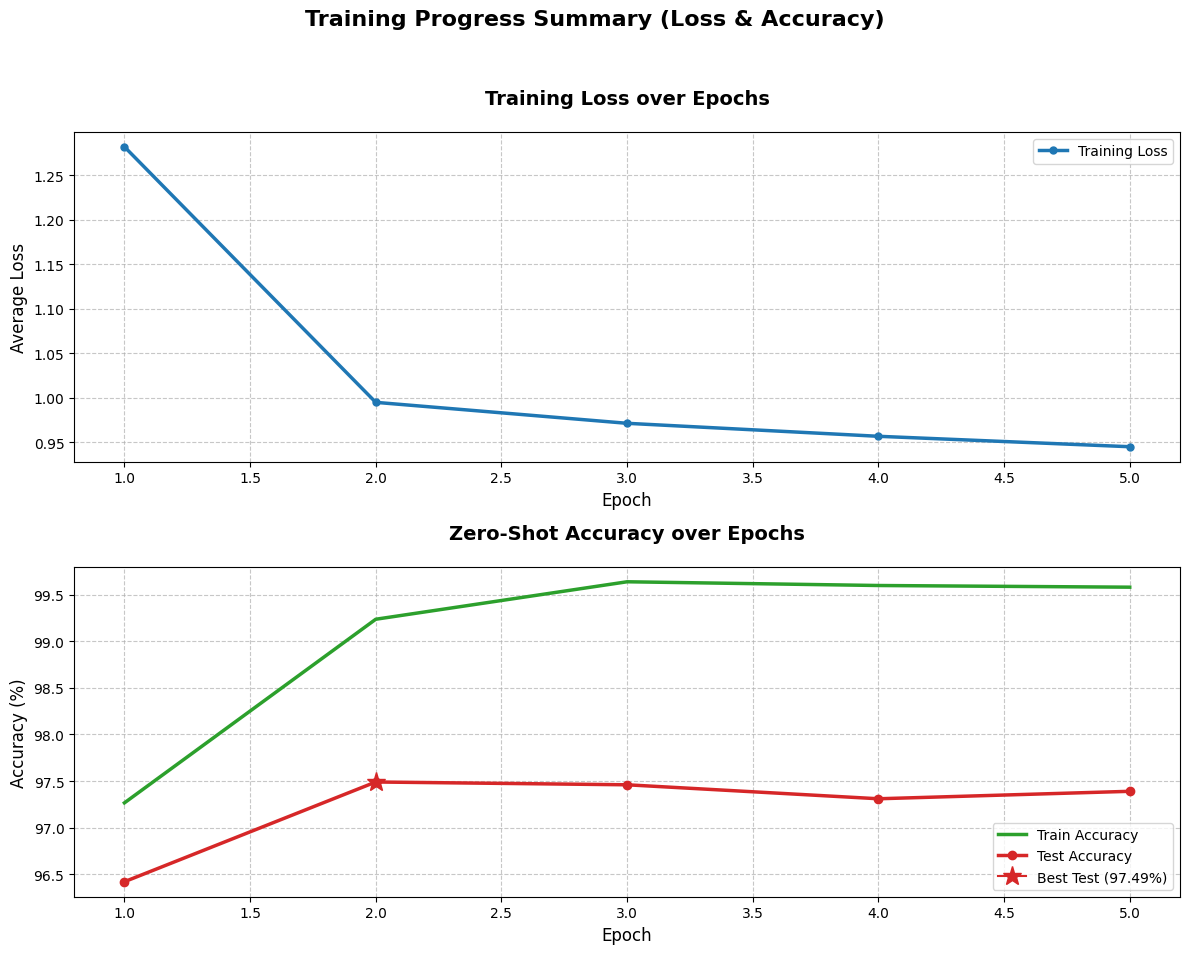

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Already used in training, but ensure imported

# Create checkpoints directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

# Zero-shot accuracy computation (assumes testloader exists from previous cells)
@torch.no_grad()
def zero_shot_accuracy(loader):
    image_model.eval()
    projection.eval()
    correct = 0
    total = 0
    for images, labels in loader:  # No tqdm here to keep evaluation fast
        images = images.to(device)
        labels = labels.to(device)

        image_features = image_model(images)
        image_features = projection(image_features)
        image_features = F.normalize(image_features, dim=-1)

        logits = logit_scale.exp() * image_features @ text_embeddings.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    image_model.train()
    projection.train()
    return acc

epochs = 5

# Lists/metrics for plotting and checkpointing
losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):
    image_model.train()
    projection.train()
    total_loss = 0.0
    optimizer.zero_grad()  # Zero once at start of epoch

    for i, (images, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            image_features = image_model(images)
            image_features = projection(image_features)
            image_features = F.normalize(image_features, dim=-1)

            logits = logit_scale.exp() * image_features @ text_embeddings.T
            loss = F.cross_entropy(logits, labels)
            loss = loss / accumulation_steps  # Scale loss for accumulation

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(trainloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # Unscale for logging

    scheduler.step()
    avg_loss = total_loss / len(trainloader)

    # Store loss
    losses.append(avg_loss)

    # Compute and store train accuracy (every epoch)
    train_acc = zero_shot_accuracy(trainloader)
    train_accs.append(train_acc)

    # Compute and store test accuracy (every epoch)
    test_acc = zero_shot_accuracy(testloader)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")

    # Optional: Clear cache every few epochs
    if (epoch + 1) % 5 == 0:
        torch.cuda.empty_cache()

# Save final checkpoint only (at the very end)
final_test_acc = test_accs[-1]
torch.save({
    'epoch': epochs,
    'image_model_state_dict': image_model.state_dict(),
    'projection_state_dict': projection.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'logit_scale': logit_scale,
    'avg_loss': losses[-1],
    'final_test_acc': final_test_acc,
}, 'checkpoints/final_model.pth')
print("Final model checkpoint saved to 'checkpoints/final_model.pth'")

# === Professional plotting after training ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=100)

# Training Loss
ax1.plot(range(1, epochs + 1), losses, color='tab:blue', linewidth=2.5, marker='o', markersize=5)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Average Loss', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(['Training Loss'], loc='upper right')

# Accuracy
ax2.plot(range(1, epochs + 1), train_accs, color='tab:green', linewidth=2.5, label='Train Accuracy')
ax2.plot(range(1, epochs + 1), test_accs, color='tab:red', linewidth=2.5, marker='o', markersize=6, label='Test Accuracy')

# Highlight best test accuracy
if test_accs:
    best_test_val = max(test_accs)
    best_test_idx = test_accs.index(best_test_val)
    best_test_epoch = best_test_idx + 1
    ax2.plot(best_test_epoch, best_test_val, color='tab:red', marker='*', markersize=14,
             label=f'Best Test ({best_test_val:.2f}%)')

ax2.set_title('Zero-Shot Accuracy over Epochs', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='lower right')

# Overall styling
fig.suptitle('Training Progress Summary (Loss & Accuracy)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Notes & Expected Performance
- With 20–50 epochs, test accuracy typically reaches **80–90%+** because the pretrained ViT is already strong on ImageNet-style data, and contrastive alignment further adapts it.
- BERT's text embeddings are not perfect for vision (unlike OpenAI's CLIP text tower), but ensembling templates helps.
- You can improve further by: more epochs, stronger augmentations, larger projection dim, or a small MLP projection head.
- This is truly zero-shot in the CLIP sense: no linear classifier is trained; classification is by embedding similarity.

In [ ]:
!pip install --upgrade calflops

In [ ]:
from calflops import calculate_flops
import torch
import torch.nn as nn

# ── Your model (same as before) ──
image_model = timm.create_model(
    'vit_small_patch16_224.augreg_in21k_ft_in1k',
    pretrained=False,
    num_classes=0
).to(device)

projection = nn.Linear(384, 768).to(device)

class ModelForFlops(nn.Module):
    def __init__(self, img_model, proj):
        super().__init__()
        self.img_model = img_model
        self.projection = proj

    def forward(self, x):
        feat = self.img_model(x)
        feat = self.projection(feat)
        return feat  # you can add F.normalize(feat, dim=-1) if you want

model = ModelForFlops(image_model, projection).eval()

# ── FLOPs calculation ──
input_shape = (1, 3, 224, 224)          # batch=1, channels=3, 224×224

flops, macs, params = calculate_flops(
    model=model,
    input_shape=input_shape,
    print_results=True,                 # prints nice table to output
    # Do NOT use: as_strings, print_per_layer_stat, output_precision, etc.
)

print("\nSummary:")
print("  FLOPs  :", flops)
print("  MACs   :", macs)
print("  Params :", params)


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  21.96 M 
fwd MACs:                                                               4.24 GMACs
fwd FLOPs:                                                              8.5 GFLOPS
fwd+bwd MACs:                                                           12.72 GMACs
fwd+bwd FLOPs:                                                          25.49 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacula